<a href="https://colab.research.google.com/github/chedabd/felix/blob/master/text_mining_tunisia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade pynytimes

     |████████████████████████████████| 62 kB 807 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
#Importation des librairies
import numpy as np
import pandas as pd
import time
import datetime
from pynytimes import NYTAPI
import re
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import FreqDist
import requests
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Api importation du token de l'API du new york times voir le compte de chedly
nyt = NYTAPI('eyuGOeXN4X7XauDTUNQ4eUtIRssmpCfi')

In [ ]:
#Parametrage des requetes
start_year = 2002
end_year = 2021
news_desk = "Foreign" #Une seule entrée
country = "Tunisia"
dictionary = "Tunisia, Terrorist, terrorists, violence, attack, army, bombs, Al-Qaida, extremism, Daech, ISIS" 

In [ ]:
articles_df = pd.DataFrame()

In [ ]:
articles = nyt.article_search(
    query="Tunis,Tunisia ",
    results =2000,
    dates = {
        "begin": datetime.datetime(start_year, 1, 31),
        "end": datetime.datetime(end_year, 12, 31)
    },
    options = {
        "sort": "oldest",
        "sources": [
            "New York Times",
            "AP",
            "Reuters",
            "International Herald Tribune"
        ],
          "news_desk": [
            (news_desk)
          ]
    }
)

/usr/local/lib/python3.7/dist-packages/pynytimes/api.py:764: UserWarning: Asking for a lot of results, because of rate limits it can take a while.
  "Asking for a lot of results, because of rate limits it can take a while."


In [8]:
#Fonction pour formater le tableau
def parse_articles(articles):
    
    news = []
    
    for i in articles:
        
        dic = {}
        dic['date'] = i['pub_date']  
        dic['atype'] = i['news_desk']
        dic['url'] = i['web_url']
        dic['word_count'] = int(i['word_count'])
        news.append(dic)
        
    return news

In [9]:
articles = parse_articles(articles)

In [10]:
all_articles = []
all_articles = all_articles + articles
articles_df = pd.DataFrame(all_articles)
articles_df.tail()

,date,atype,url,word_count
294,2021-08-26T16:28:47+0000,Foreign,https://www.nytimes.com/2021/08/26/world/middl...,1476
295,2021-09-27T12:27:40+0000,Foreign,https://www.nytimes.com/2021/09/27/world/middl...,936
296,2021-09-29T12:27:06+0000,Foreign,https://www.nytimes.com/2021/09/29/world/afric...,649
297,2021-10-10T17:47:16+0000,Foreign,https://www.nytimes.com/2021/10/10/world/middl...,1419
298,2021-10-17T14:27:02+0000,Foreign,https://www.nytimes.com/2021/10/17/world/middl...,1261


In [11]:
articles_df = articles_df.drop(articles_df[articles_df.atype != 'Foreign'].index)
articles_df.drop('atype', axis = 1, inplace = True)
articles_df.tail()

,date,url,word_count
294,2021-08-26T16:28:47+0000,https://www.nytimes.com/2021/08/26/world/middl...,1476
295,2021-09-27T12:27:40+0000,https://www.nytimes.com/2021/09/27/world/middl...,936
296,2021-09-29T12:27:06+0000,https://www.nytimes.com/2021/09/29/world/afric...,649
297,2021-10-10T17:47:16+0000,https://www.nytimes.com/2021/10/10/world/middl...,1419
298,2021-10-17T14:27:02+0000,https://www.nytimes.com/2021/10/17/world/middl...,1261


In [12]:
#Retrait des articles vides
articles_df = articles_df[articles_df.word_count != 0]
articles_df = articles_df.reset_index(drop = True)
articles_df.tail()

,date,url,word_count
291,2021-08-26T16:28:47+0000,https://www.nytimes.com/2021/08/26/world/middl...,1476
292,2021-09-27T12:27:40+0000,https://www.nytimes.com/2021/09/27/world/middl...,936
293,2021-09-29T12:27:06+0000,https://www.nytimes.com/2021/09/29/world/afric...,649
294,2021-10-10T17:47:16+0000,https://www.nytimes.com/2021/10/10/world/middl...,1419
295,2021-10-17T14:27:02+0000,https://www.nytimes.com/2021/10/17/world/middl...,1261


In [13]:
#Fonction de Scraping des articles
def scarp_articles_text(articles_df):
    
    # Unable false positive warning from Pandas dataframe manipulation
    pd.options.mode.chained_assignment = None
    
    articles_df['article_text'] = 'NaN'
    session = requests.Session()
    
    print('Scarping articles body text...'),
    
    for j in range(0, len(articles_df)):
        
        url = articles_df['url'][j]
        req = session.get(url)
        soup = BeautifulSoup(req.text, 'lxml')

        # Get only HTLM tags with article content
        # Articles through 1986 are found under different p tag 
        
        paragraph_tags = soup.find_all("div", {"class": "css-1fanzo5 StoryBodyCompanionColumn"})
        if paragraph_tags == []:
            paragraph_tags = soup.find_all('p', itemprop = 'articleBody')
        '''
        paragraph_tags = soup.find_all('p')
        if paragraph_tags == []:
          paragraph_tags = soup.find_all('p', itemprop ='articleBody')
        '''
        # Put together all text from HTML p tags
        article = ''
        for p in paragraph_tags:
            article = article + ' ' + p.get_text()

        # Clean article replacing unicode characters
        article = article.replace(u'\u2018', u"'").replace(u'\u2019', u"'").replace(u'\u201c', u'"').replace(u'\u201d', u'"')

        # Copy article's content to the dataframe
        articles_df['article_text'][j] = article
    
    print('Done!')
    
    return articles_df


In [14]:
# Get Article Text
articles_df = scarp_articles_text(articles_df)
articles_df.tail()

Scarping articles body text...
Done!


,date,url,word_count,article_text
291,2021-08-26T16:28:47+0000,https://www.nytimes.com/2021/08/26/world/middl...,1476,
292,2021-09-27T12:27:40+0000,https://www.nytimes.com/2021/09/27/world/middl...,936,
293,2021-09-29T12:27:06+0000,https://www.nytimes.com/2021/09/29/world/afric...,649,
294,2021-10-10T17:47:16+0000,https://www.nytimes.com/2021/10/10/world/middl...,1419,
295,2021-10-17T14:27:02+0000,https://www.nytimes.com/2021/10/17/world/middl...,1261,


In [15]:
#Pre processing des données
def tokenize(text):
    
    # Convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    
    # Remove stop words
    cachedStopWords = stopwords.words("english")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # Steam the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
    
    # Remove non-letters 
    p = re.compile('[a-zA-Z]+')
    
    # Remove less than 3 length words
    min_length = 3
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    
    return filtered_tokens

In [ ]:
def text_mine_articles(articles_df, bag_of_words):
    
    articles_df = articles_df.drop(articles_df[articles_df.word_count == 0].index) # 1991 art 21 prevensio
    articles_df = articles_df.reset_index(drop = True)
    
    bag_of_words = tokenize(bag_of_words)
    articles_df['num_occurr'] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    
    for j in range(0, len(articles_df)):
        
        # Convert article body into a list of tokens
        tokenized_article = tokenize(articles_df['article_text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        
        # Copy amount of occurrences found to the dataframe
        amount = len(occurrences)
        articles_df['num_occurr'][j] = amount
        
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    articles_df['freq_occurr'] = articles_df['num_occurr']/articles_df['word_count']   
   
    print('Done!')
 
    return articles_df

In [ ]:
# Article pre-processing and word count
articles_df = text_mine_articles(articles_df, dictionary)
articles_df.tail()

Text mine articles...
Done!


,date,url,word_count,article_text,num_occurr,freq_occurr
287,2021-07-27T22:36:55+0000,https://www.nytimes.com/2021/07/27/world/afric...,1178,TUNIS — With large gatherings banned by a pre...,9,0.007640
288,2021-07-28T22:12:04+0000,https://www.nytimes.com/2021/07/28/world/afric...,1164,"GAZIANTEP, Turkey — In the 10 years since its...",16,0.013746
289,2021-08-01T11:47:32+0000,https://www.nytimes.com/2021/08/01/world/middl...,1541,TUNIS — The man who critics were warning coul...,10,0.006489
290,2021-08-05T13:53:39+0000,https://www.nytimes.com/2021/08/05/world/afric...,1281,"TEBOURBA, Tunisia — Aroussi Mejri, a 40-year-...",11,0.008587
291,2021-08-26T16:28:47+0000,https://www.nytimes.com/2021/08/26/world/middl...,1476,"TUNIS — Year after year, the man now accused ...",8,0.005420


In [ ]:
articles_df.to_excel("output_article 2000-2020.xlsx")  

In [ ]:
def get_monthly_results(articles_df, start_year, end_year):
    
    print('Arranging results monthly into a new dataframe...'),
    
    # Number of months in range of analysis
    range = 12*(end_year - start_year + 1)
    
    # Prepare timeseries dataframe for displaying results
    columns = ['month_freq_occurr', 'num_articles','norm_freq_occurr']
    results_df = pd.DataFrame(columns = columns)
    results_df['date'] = pd.date_range(str(start_year) + '-01', periods = range, freq = 'M')
    
    # Set date as index to move data from articles_df to results_df conviniently
    results_df = results_df.set_index(['date'])
    results_df = results_df.fillna(0.0) # with 0s rather than NaNs
    
    # Display results on a monthly basis
    i = 0
    while i < len(articles_df):
        
        # Cut day from date column
        date = articles_df['date'][i][0:7] 
        
        # Group numbers monthly by summing daily results
        results_df.loc[date]['num_articles'] += 1
        results_df.loc[date]['month_freq_occurr'] += articles_df['freq_occurr'][i]
        
        i += 1
    
    # Normalize the monthly added frequency of occurrences by the amount of articles published in that month
    results_df['norm_freq_occurr'] = results_df['month_freq_occurr']/results_df['num_articles']
    
    # Detele the NaN divisions if any
    results_df['norm_freq_occurr'][results_df['norm_freq_occurr'].isnull()] = 0.0
    
    print('Done!')
    
    return results_df


In [ ]:
# Build the Resulting Monthly Time Series
results_df = get_monthly_results(articles_df, start_year, end_year)
results_df.head()

Arranging results monthly into a new dataframe...
Done!


,month_freq_occurr,num_articles,norm_freq_occurr
date,,,
2002-01-31,0.0,0.0,0.0
2002-02-28,0.0,0.0,0.0
2002-03-31,0.0,0.0,0.0
2002-04-30,0.0,0.0,0.0
2002-05-31,0.0,0.0,0.0


In [ ]:
def visualize_results(results_df, start_year, end_year, dictionary):
    
    # Print on Jupyter Notebook
    get_ipython().magic(u'matplotlib inline')
    
    # Define plot properties
    plot_title = 'Results for Dictionary: "' + dictionary + '" in '  + ' from Jan ' + str(start_year) + ' to Dec ' + str(end_year)
    results_df.norm_freq_occurr.plot(legend = True, label = 'Monthly Normalized Frequency of Occurrence', 
                                        figsize = (15, 5), title = plot_title)
    results_df.num_articles.plot(secondary_y = True, style = 'g',
                                    label = 'Articles Published', legend = True)

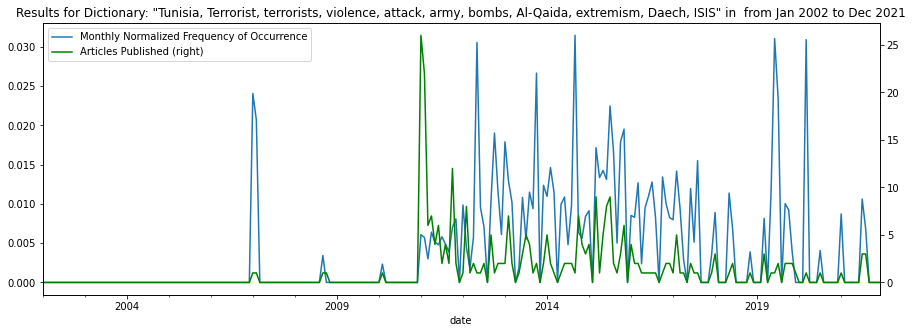

In [ ]:
# Visualize Results
visualize_results(results_df, start_year, end_year, dictionary)

In [ ]:
results_df.to_excel("output2000-2020.xlsx")  